Back to the main [Index](../index.ipynb)

### Model Loading

To load models use any the following functions. Each function takes a model with the corresponding format and converts it to a [RoadRunner](http://sys-bio.github.io/roadrunner/python_docs/index.html) simulator instance.

* `te.loadAntimony` (`te.loada`): Load an Antimony model.
* `te.loadSBML`: Load an SBML model.
* `te.loadCellML`: Load a CellML model (this passes the model through Antimony and converts it to SBML, may be lossy).

In [30]:
from __future__ import print_function
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
%matplotlib inline

model = """
model test
    compartment C1;
    C1 = 1.0;
    species S1, S2;
    
    S1 = 10.0;
    S2 = 0.0;
    S1 in C1; S2 in C1;
    J1: S1 -> S2; k1*S1;
    
    k1 = 1.0;
end
"""
# load models
r = te.loada(model)

### Integrator and Integrator Settings
To set the integrator use `r.setIntegrator(<integrator-name>)` or `r.integrator = <integrator-name>`. RoadRunner supports `'cvode'`, `'gillespie'`, and `'rk4'` for the integrator name. CVODE uses adaptive stepping internally, regardless of whether the output is gridded or not. The size of these internal steps is controlled by the tolerances, both absolute and relative.

To set integrator settings use `r.integrator.<setting-name> = <value>` or `r.integrator.setValue(<setting-name>, <value>)`. Here are some important settings for the `cvode` integrator:

* `variable_step_size`: Adaptive step-size integration (`True`/`False`).
* `stiff`: Stiff solver for CVODE only (`True`/`False`). Enabled by default.
* `absolute_tolerance`: Absolute numerical tolerance for integrator internal stepping.
* `relative_tolerance`: Relative numerical tolerance for integrator internal stepping.

Settings for the `gillespie` integrator:

* `seed`: The RNG seed for the Gillespie method. You can set this before running a simulation, or leave it alone for a different seed each time. Simulations initialized with the same seed will have the same results.

The current integrator is:
< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 0.000000000001
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false



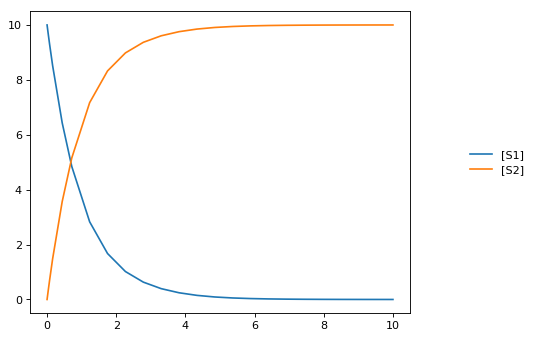

Time values:
[  0.00000000e+00   3.43225906e-07   3.43260229e-03   3.77551929e-02
   7.20777836e-02   1.60810095e-01   4.37546265e-01   7.14282434e-01
   1.23145372e+00   1.74862501e+00   2.26579629e+00   2.78296758e+00
   3.30013887e+00   3.81731015e+00   4.33448144e+00   4.85165273e+00
   5.36882401e+00   5.88599530e+00   6.40316659e+00   6.92033787e+00
   7.43750916e+00   7.95468045e+00   8.47185173e+00   9.25832855e+00
   1.00000000e+01]


In [31]:
# what is the current integrator?
print('The current integrator is:')
print(r.integrator)

# enable variable stepping
r.integrator.variable_step_size = True
# adjust the tolerances (can set directly or via setValue)
r.integrator.absolute_tolerance = 1e-3 # set directly via property
r.integrator.setValue('relative_tolerance', 1e-1) # set via a call to setValue

# run a simulation, stop after reaching or passing time 10
results = r.simulate(0, 10)
r.plot()

# print the time values from the simulation
print('Time values:')
print(results[:,0])

In [6]:
# set integrator to Gillespie solver
r.setIntegrator('gillespie')
# identical ways to set integrator
r.setIntegrator('rk4')
r.integrator = 'rk4'
# set back to cvode (the default)
r.setIntegrator('cvode')

# set integrator settings
r.integrator.setValue('variable_step_size', False)
r.integrator.setValue('stiff', True)

# print integrator settings
print(r.integrator)

< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 0.001
      absolute_tolerance: 0.000001
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false



### Simulation options

The `RoadRunner.simulate` method is responsible for running simulations using the current integrator. It accepts the following arguments:

* `start`: Start time.
* `end`: End time.
* `points`: Number of points in solution (exclusive with steps, do not pass both). If the output is gridded, the points will be evenly spaced in time. If not, the simulation will stop when it reaches the `end` time or the number of points, whichever happens first.
* `steps`: Number of steps in solution (exclusive with points, do not pass both).



In [7]:
# simulate from 0 to 6 with 6 points in the result
r.reset()
# pass args explicitly via keywords
res1 = r.simulate(start=0, end=10, points=6)
print(res1)
r.reset()
# use positional args to pass start, end, num. points
res2 = r.simulate(0, 10, 6)
print(res2)

    time,        [S1],    [S2]
 [[    0,          10,       0],
  [    2,     1.35716, 8.64284],
  [    4,    0.182759, 9.81724],
  [    6,   0.0247971,  9.9752],
  [    8,  0.00338114, 9.99662],
  [   10, 0.000460568, 9.99954]]

    time,        [S1],    [S2]
 [[    0,          10,       0],
  [    2,     1.35716, 8.64284],
  [    4,    0.182759, 9.81724],
  [    6,   0.0247971,  9.9752],
  [    8,  0.00338114, 9.99662],
  [   10, 0.000460568, 9.99954]]



### Selections

The selections list can be used to set which state variables will appear in the output array. By default, it includes all SBML species and the `time` variable. Selections can be either given as argument to `r.simulate` or set via `r.selections`.

In [8]:
# set selections directly
r.selections = ['time', 'J1']
print(r.simulate(0,10,6))
# provide arguments to simulate
print(r.simulate(0,10,6, selections=r.getFloatingSpeciesIds()))

    time,          J1
 [[    0, 0.000460568],
  [    2, 5.95825e-05],
  [    4, 7.43537e-06],
  [    6, 1.21182e-06],
  [    8, 3.84777e-07],
  [   10, 6.63059e-08]]

             S1, S2
 [[ 6.63059e-08, 10],
  [ 2.77435e-08, 10],
  [ 1.01251e-08, 10],
  [ 6.84866e-09, 10],
  [ 4.72989e-09, 10],
  [ 2.61112e-09, 10]]



### Reset model variables
To reset the model's state variables use the `r.reset()` and `r.reset(SelectionRecord.*)` functions. If you have made modifications to parameter values, use the `r.resetAll()` function to reset parameters to their initial values when the model was loaded.

In [9]:
# show the current values
for s in ['S1', 'S2']:
    print('r.{} == {}'.format(s, r[s]))
# reset initial concentrations
r.reset()
print('reset')
# S1 and S2 have now again the initial values
for s in ['S1', 'S2']:
    print('r.{} == {}'.format(s, r[s]))

r.S1 == 2.6111239010134025e-09
r.S2 == 9.999999997388876
reset
r.S1 == 10.0
r.S2 == 0.0
